In [3]:
from IPython.display import display, Image

from dotenv import load_dotenv
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama

In [4]:
llm = ChatOllama(
    model="gpt-oss:120b-cloud"  # e.g., "gpt-oss:120b-cloud"
)


In [5]:
#stucture output type
class MessageClassifier(BaseModel):
    message_type: Literal["emotional","logical"] = Field(
        ...,
        description="Classify if the message requires an emotiional (therapist) or logical response."
    )

#you can define "next" state if you want 
class State(TypedDict): 
    #messages are type of list
    messages: Annotated[list, add_messages]
    message_type: str | None

In [7]:
#updating the state message_type to either logical or emotional
def classify_messsages(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        {
            "role": "system",
            "content": """Classify the user message as either 'emotional' or 'logical'.
            
            Respond ONLY with valid JSON in this exact format:
            {"message_type": "emotional"}
            or
            {"message_type": "logical"}
            
            Rules:
            - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
            - 'logical': if it asks for facts, information, logical analysis, or practical solutions
            
            Do not include any other text, just the JSON object.
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }  
        ])
    return {"message_type": result.message_type}

#route to logical or therapist based on message_type
def router(state: State):
    #message not classified properly default to logical
    message_type = state.get("message_type","logical")
    if message_type == "emotional":
        return {"next": "therapist"}
    
    return {"next": "logical"}


def therapist_agent(state: State):
    last_message = state["messages"][-1]
    messages = [
        {"role": "system", 
         "content": """
            You are a compassionate therapist. Focus on the emotional aspects of the user's message.
            Show empathy, validate their feelings, and help them process their emotions.
            Ask thoughtful questions to help them explore their feelings more deeply.
            Avoid giving logical solutions unless explicitly asked.
            """
         },
         {
             "role": "user",
             "content": last_message.content
         }
    ]

    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

def logical_agent(state: State):
        last_message = state["messages"][-1]
        messages = [
            {"role": "system", 
            "content": """
                You are a purely loogical assisant. Focus only on facts and information.
                Provide clear, concise answers based on logic and evidence.
                Do not address emotions or provide emotional support.
                Be direct and straightforward in your responses.
                """
            },
            {
                "role": "user",
                "content": last_message.content
            }
        ]

        reply = llm.invoke(messages)
        return {"messages": [{"role": "assistant", "content": reply.content}]}

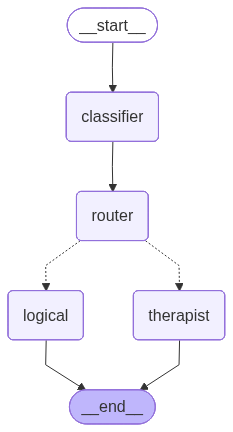

In [8]:
graph_builder = StateGraph(State)
graph_builder.add_node("classifier",classify_messsages)
graph_builder.add_node("router", router)
graph_builder.add_node("therapist",therapist_agent)
graph_builder.add_node("logical",logical_agent)

graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier","router")
graph_builder.add_conditional_edges(
     "router",
     lambda state: state.get("next"),
     {"therapist": "therapist","logical":"logical"}
     )

graph_builder.add_edge("therapist", END)
graph_builder.add_edge("logical", END)


graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def run_chatbot():
    state = {"messages": [], "message_type": None}

    while True:
         user_input = input("Message: ")
         if user_input == 'exit':
            print("Bye")
            break
         
         #empty list if cannot get state messages, add new message to state
         state["messages"] = state.get("messages",[]) + [
             {"role": "user", "content": user_input}
         ]

         state = graph.invoke(state)

         if state.get("messages") and len(state["messages"]) > 0:
             last_message = state["messages"][-1]
             print(f"Assisant: {last_message.content}")

if __name__ == "__main__":
    run_chatbot()